In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gc
import time
import subprocess
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit import RDConfig
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, rdDistGeom, rdPartialCharges
from rdkit.Chem.AllChem import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2024-10-22 14:26:21.293012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:26:21.310670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:26:21.314346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:26:21.325676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 14:26:20.524434: W tensorflow/compiler/tf2

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [5]:
import plotly.graph_objects as go

In [6]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1729574782.487297   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729574782.528655   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729574782.528749   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [7]:
target_path = "result/1_standard_ML"
os.makedirs(target_path, exist_ok=True)

In [8]:
data_ws = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
smiles_ws = data_ws['SMILES']
y_ws = data_ws.iloc[:, 2]

data_delaney = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
smiles_de = data_delaney['smiles']
y_de = data_delaney.iloc[:, 1]

data_lovric2020 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
smiles_lo = data_lovric2020['isomeric_smiles']
y_lo = data_lovric2020.iloc[:, 1]

data_huuskonen = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
smiles_hu = data_huuskonen['SMILES']
y_hu = data_huuskonen.iloc[:, -1].astype('float')

data_bigsoldb = pd.read_csv('./data/BigSolDB.csv', dtype={'SMILES':'string'})
smiles_bd = data_bigsoldb['SMILES']
y_bd = data_bigsoldb.iloc[:, 2].astype('float')

data_aqsoldb = pd.read_csv('./data/curated-solubility-dataset.csv', dtype={'SMILES':'string'})
smiles_aq = data_aqsoldb['SMILES']
y_aq = data_aqsoldb.iloc[:, 5].astype('float')

In [9]:
def plot_advanced_histograms(data_frames, save_path="result/dataset_plot"):
    save_path = os.path.join(save_path, 'histogram')
    os.makedirs(save_path, exist_ok=True)

    for df_name, (smiles, y_values) in data_frames.items():
        print(f"Processing dataset: {df_name}")
        
        outliers_txt_path = os.path.join(save_path, f"{df_name}_outliers_info.txt")  # Fixed path
        
        with open(outliers_txt_path, 'w') as outlier_file:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Histogram with KDE plot
            sns.histplot(y_values, bins=30, kde=True, ax=ax, color='blue', alpha=0.6, edgecolor='black')  # Fixed bins
            
            # IQR for outlier detection
            Q1 = np.percentile(y_values, 25)
            Q3 = np.percentile(y_values, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = y_values[(y_values < lower_bound) | (y_values > upper_bound)]
            
            outlier_indices = np.where((y_values < lower_bound) | (y_values > upper_bound))[0]
            if len(outlier_indices) > 0:
                outlier_file.write(f"Outliers for {df_name}:\n")
                for idx in outlier_indices:
                    # Adjusted to handle indexing in case smiles is not a Series
                    outlier_info = f"Index: {idx}, SMILES: {smiles[idx]}, Value: {y_values[idx]}\n"  # Fixed indexing
                    outlier_file.write(outlier_info)
            
            # Mark outliers on the plot
            ax.scatter(outliers, np.zeros_like(outliers), color='red', s=10, label=f'Outliers: {len(outliers)}')
            
            # Mean, median, standard deviation
            mean_val = np.mean(y_values)
            median_val = np.median(y_values)
            std_val = np.std(y_values)
            
            ax.axvline(mean_val, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='g', linestyle='-', linewidth=1.5, label=f'Median: {median_val:.2f}')
            ax.fill_betweenx([0, ax.get_ylim()[1]], mean_val - std_val, mean_val + std_val, color='r', alpha=0.1, label=f'STD: ±{std_val:.2f}')
            
            # Dynamic X range adjustment based on IQR
            ax.set_xlim(lower_bound - IQR, upper_bound + IQR)
            
            ax.set_title(f"Histogram and KDE with Outliers for {df_name}")
            ax.set_xlabel('LogS')
            ax.set_ylabel('Frequency')
            ax.legend()
            ax.grid(axis='y', alpha=0.75)
            
            # Save plot
            fig_save_path = os.path.join(save_path, f"{df_name}_histogram_kde.png")  # Fixed path
            plt.savefig(fig_save_path, dpi=300, bbox_inches='tight')
            print(f"File saved to: {fig_save_path}")
            
            # Show plot
            plt.show()
            plt.close(fig)

Processing dataset: ws496
File saved to: result/1_standard_ML/histogram/ws496_histogram_kde.png


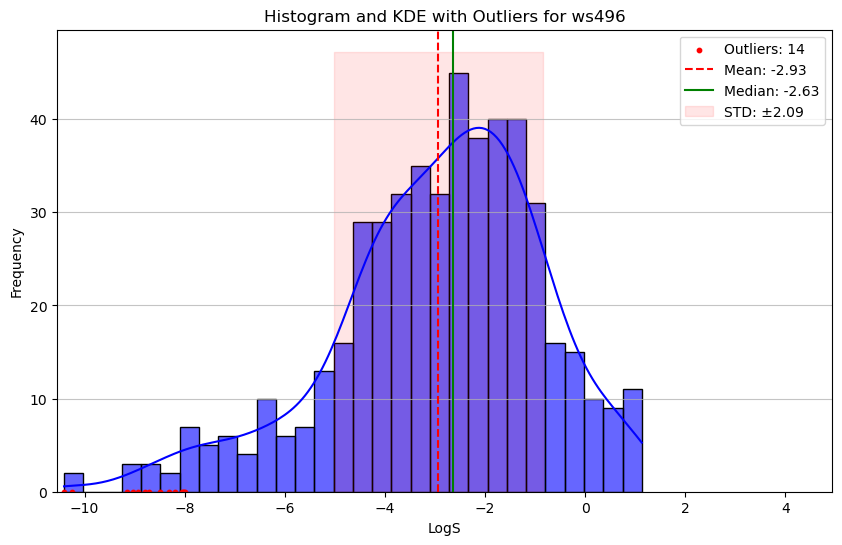

Processing dataset: delaney
File saved to: result/1_standard_ML/histogram/delaney_histogram_kde.png


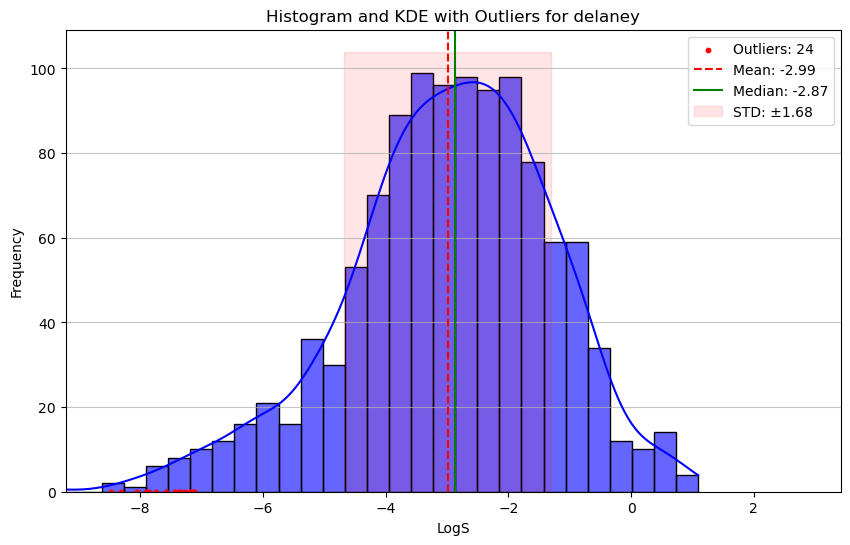

Processing dataset: lovric
File saved to: result/1_standard_ML/histogram/lovric_histogram_kde.png


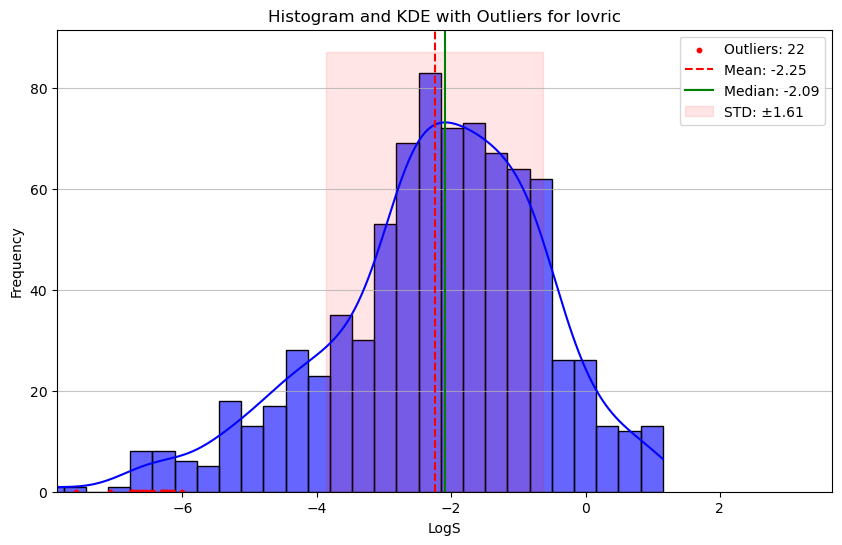

Processing dataset: huusk
File saved to: result/1_standard_ML/histogram/huusk_histogram_kde.png


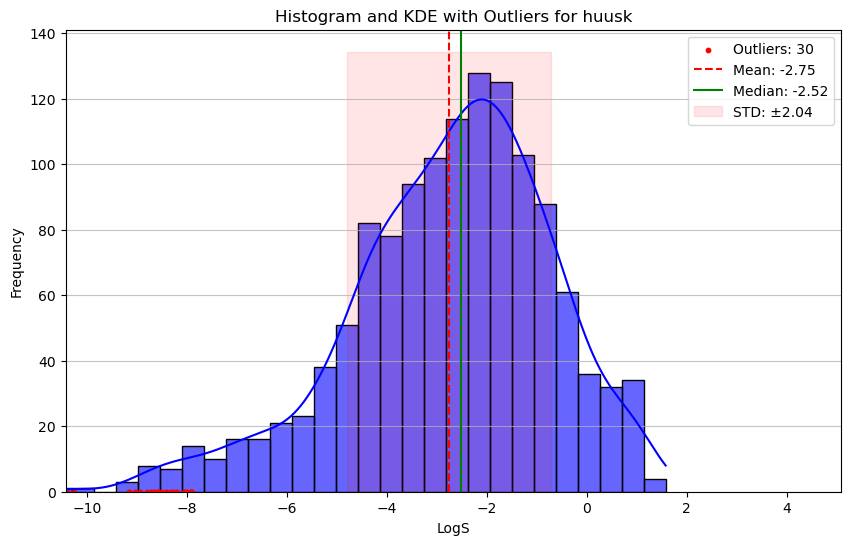

Processing dataset: AqSolDb
File saved to: result/1_standard_ML/histogram/AqSolDb_histogram_kde.png


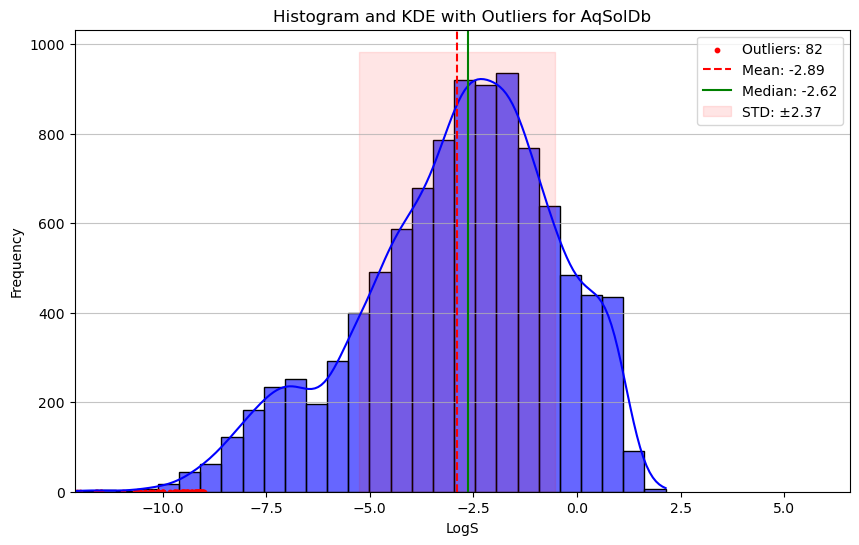

Processing dataset: BigSolDB
File saved to: result/1_standard_ML/histogram/BigSolDB_histogram_kde.png


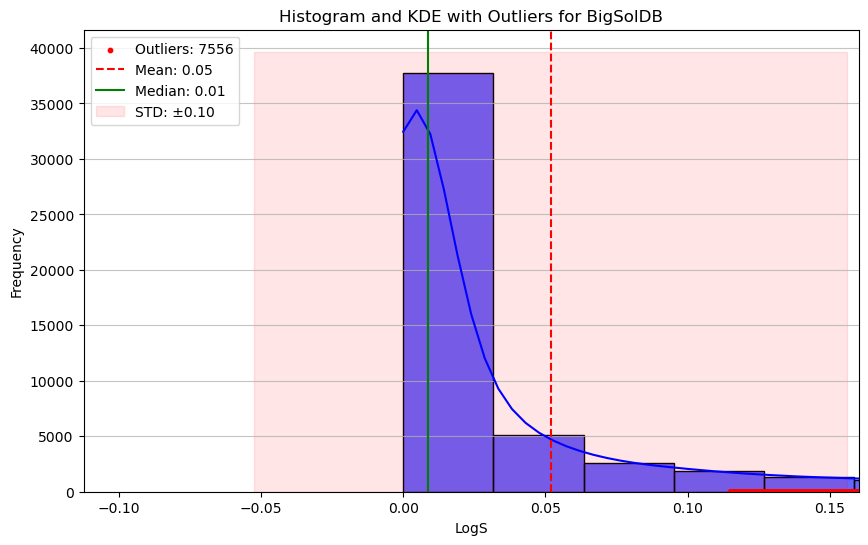

In [10]:
data_frames = {
    'ws496': (smiles_ws, y_ws),
    'delaney': (smiles_de, y_de),
    'lovric': (smiles_lo, y_lo),
    'huusk': (smiles_hu, y_hu),
    'AqSolDb':(smiles_aq, y_aq),
    'BigSolDB':(smiles_bd,y_bd),
}
plot_advanced_histograms(data_frames, target_path)

In [11]:
data_dict = {
    'ws496': y_ws,
    'delaney': y_de,
    'lovric': y_lo,
    'huusk': y_hu
}

In [12]:
def plot_combined_histogram(data, save_path="result/dataset_plot"):
    os.makedirs(save_path, exist_ok=True)

    if isinstance(data, dict):
        data = pd.DataFrame(data)
    
    dataset_names = data.columns
    num_datasets = len(dataset_names)
    
    all_data = np.concatenate([data[col].dropna().values for col in dataset_names])
    bins = np.linspace(min(all_data), max(all_data), 31)
    
    counts_list = [np.histogram(data[col].dropna(), bins=bins)[0] for col in dataset_names]
    
    fig = go.Figure()
    bin_centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.7

    for i, col in enumerate(dataset_names):
        fig.add_trace(go.Bar(x=bin_centers, y=counts_list[i], width=width, name=col))
    
    fig.update_layout(
        barmode='group',
        xaxis_title='LogS',
        yaxis_title='Frequency',
        title='Combined Histogram of LogS Values',
        legend=dict(x=0.1, y=0.9, bgcolor='rgba(255,255,255,0.5)'),
        template='plotly_white'
    )
    
    # HTML 저장
    html_save_file_path = f"{save_path}/LogS_Frequency_plotly.html"
    fig.write_html(html_save_file_path)
    print(f"HTML file saved to: {html_save_file_path}")
    
    fig.show()
plot_combined_histogram(data_dict, target_path)

HTML file saved to: result/1_standard_ML/LogS_Frequency_plotly.html


PNG file saved to: result/1_standard_ML/LogS_Frequency_seaborn.png


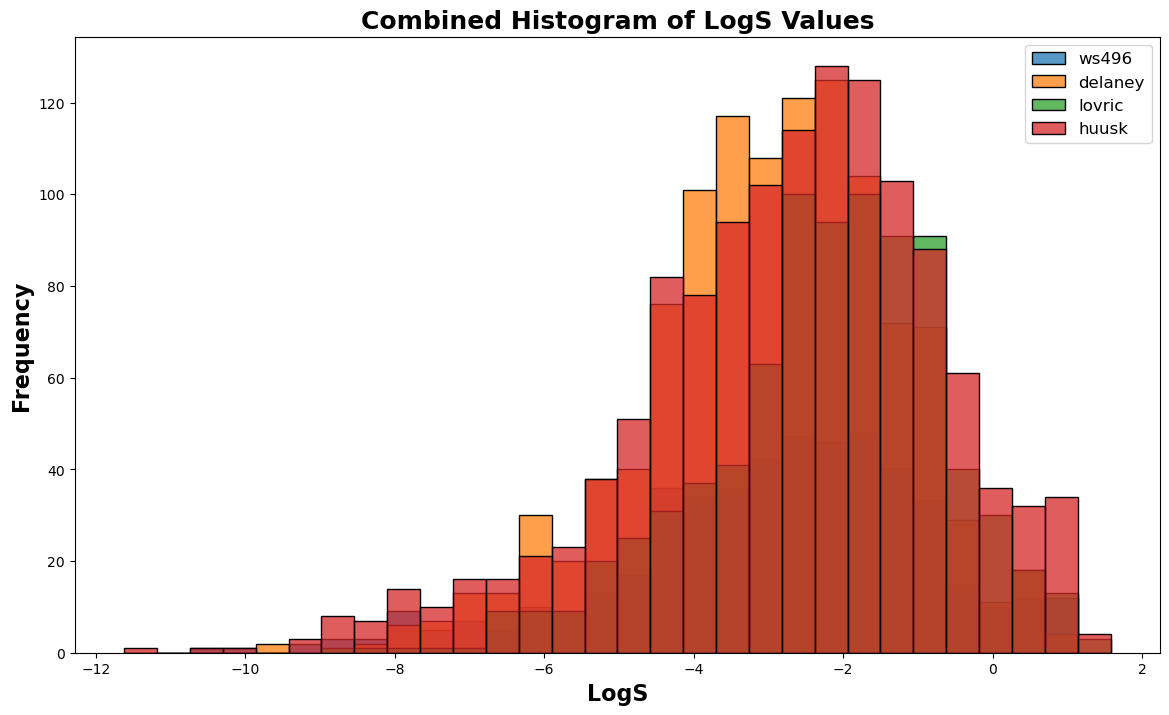

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_combined_histogram(data, save_path="result/dataset_plot"):
    os.makedirs(save_path, exist_ok=True)
    
    if isinstance(data, dict):
        data = pd.DataFrame(data)
    
    dataset_names = data.columns
    all_data = np.concatenate([data[col].dropna().values for col in dataset_names])
    bins = np.linspace(min(all_data), max(all_data), 31)

    plt.figure(figsize=(14, 8))

    for col in dataset_names:
        sns.histplot(data[col].dropna(), bins=bins, label=col, kde=False, edgecolor='black')

    plt.legend(loc='upper right', fontsize=12)
    plt.xlabel('LogS', fontsize=16, weight='bold')
    plt.ylabel('Frequency', fontsize=16, weight='bold')
    plt.title('Combined Histogram of LogS Values', fontsize=18, weight='bold')

    # Save as PNG
    png_save_file_path = f"{save_path}/LogS_Frequency_seaborn.png"
    plt.savefig(png_save_file_path, dpi=300)
    print(f"PNG file saved to: {png_save_file_path}")

    # Show plot
    plt.show()

plot_combined_histogram(data_dict, target_path)

array([[<Axes: title={'center': 'ws496'}>,
        <Axes: title={'center': 'delaney'}>],
       [<Axes: title={'center': 'lovric'}>,
        <Axes: title={'center': 'huusk'}>]], dtype=object)

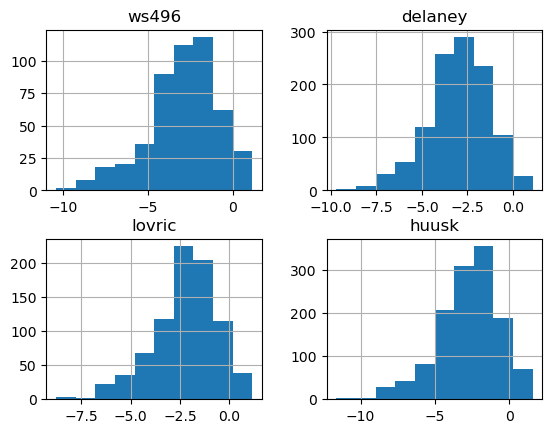

In [14]:
pd.DataFrame(data_dict).hist()

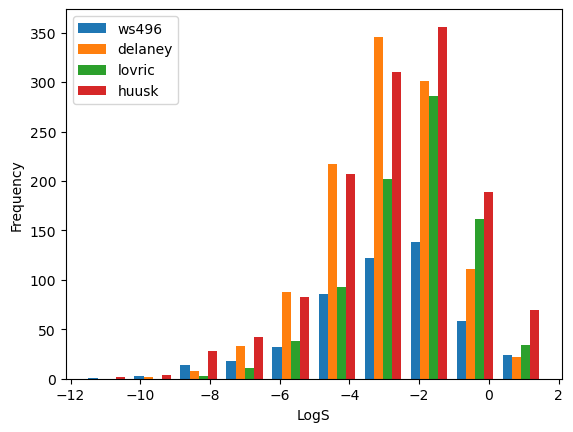

In [15]:
plt.hist([y_ws, y_de,y_lo,y_hu], label=['ws496','delaney','lovric','huusk'])
plt.legend(loc='upper left')
plt.xlabel('LogS')
plt.ylabel('Frequency')
plt.savefig(f"{target_path}/1_LogS_Frequency.png", dpi=300)
plt.show()

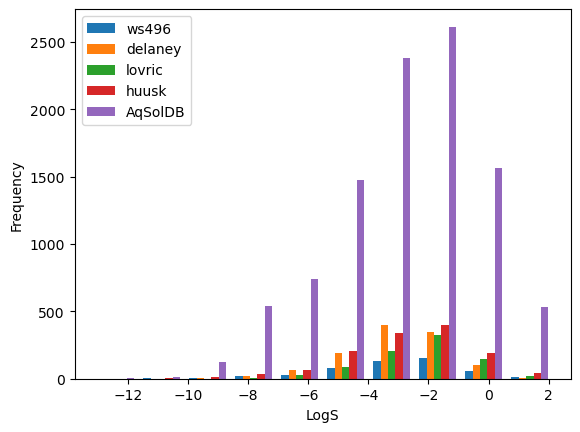

In [16]:
plt.hist([y_ws, y_de,y_lo,y_hu,y_aq], label=['ws496','delaney','lovric','huusk','AqSolDB'])
plt.legend(loc='upper left')
plt.xlabel('LogS')
plt.ylabel('Frequency')
plt.savefig(f"{target_path}/1_LogS_Frequency_with_aq.png", dpi=300)
plt.show()

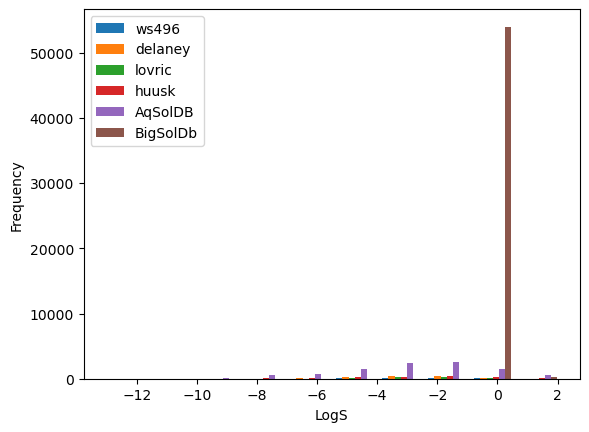

In [17]:
plt.hist([y_ws, y_de,y_lo,y_hu,y_aq,y_bd], label=['ws496','delaney','lovric','huusk','AqSolDB','BigSolDb'])
plt.legend(loc='upper left')
plt.xlabel('LogS')
plt.ylabel('Frequency')
plt.savefig(f"{target_path}/1_LogS_Frequency_with_all.png", dpi=300)
plt.show()

In [18]:
def mol3d(mol):
    mol = Chem.AddHs(mol)
    optimization_methods = [
        (AllChem.EmbedMolecule, (mol, AllChem.ETKDGv3()), {}),
        (AllChem.UFFOptimizeMolecule, (mol,), {'maxIters': 200}),
        (AllChem.MMFFOptimizeMolecule, (mol,), {'maxIters': 200})
    ]

    for method, args, kwargs in optimization_methods:
        try:
            method(*args, **kwargs)
            if mol.GetNumConformers() > 0:
                return mol
        except ValueError as e:
            print(f"Error: {e} - Trying next optimization method [{method}]")

    print(f"Invalid mol for 3d {'\033[94m'}{Chem.MolToSmiles(mol)}{'\033[0m'} - No conformer generated")
    return None

In [19]:
def convert_smiles_to_mol(smiles, fail_folder=None, index=None, yvalue=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"[convert_smiles_to_mol] Cannot convert {smiles} to Mols")
        return None, {"smiles": smiles, "y_value": yvalue, "error": "Invalid SMILES"}

    try:
        Chem.Kekulize(mol, clearAromaticFlags=True)
        isomeric_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol = Chem.MolFromSmiles(isomeric_smiles)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} isomeric_smiles by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"Isomeric SMILES error: {e}"}

    try:
        Chem.SanitizeMol(mol)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} SanitizeMol by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"SanitizeMol error: {e}"}

    return mol, None

In [20]:
def process_smiles(smiles, yvalue, fail_folder, index):
    mol, error = convert_smiles_to_mol(smiles, fail_folder, index, yvalue)
    if error:
        return None, None, error

    mol_3d = mol3d(mol)
    if mol_3d:
        return smiles, yvalue, None
    else:
        img_path = os.path.join(fail_folder, f"mol_{index}.png")
        img = Draw.MolToImage(mol)
        img.save(img_path)
        return None, None, {"smiles": smiles, "y_value": yvalue}

def process_dataset(smiles_list, y_values, dataset_name, target_path="result", max_workers=None):
    start = time.time()
    valid_smiles, valid_y = [], []
    error_smiles_list = []
    fail_folder = f"{target_path}/failed/{dataset_name}"
    os.makedirs(fail_folder, exist_ok=True)

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_smiles, smiles, yvalue, fail_folder, i)
            for i, (smiles, yvalue) in enumerate(zip(smiles_list, y_values))
        ]
        for future in as_completed(futures):
            smiles, yvalue, error = future.result()
            if error:
                error_smiles_list.append(error)
            elif smiles is not None and yvalue is not None:
                valid_smiles.append(smiles)
                valid_y.append(yvalue)

    if error_smiles_list:
        error_df = pd.DataFrame(error_smiles_list)
        error_df.to_csv(os.path.join(fail_folder, "failed_smiles.csv"), index=False)
    print(f" [{dataset_name:<10}] : {time.time()-start:.4f} sec")
    return valid_smiles, valid_y

In [21]:
smiles_ws, y_ws = process_dataset(smiles_ws, y_ws, "ws496", target_path)
smiles_de, y_de = process_dataset(smiles_de, y_de, "delaney", target_path)
smiles_lo, y_lo = process_dataset(smiles_lo, y_lo, "Lovric2020_logS0", target_path)
smiles_hu, y_hu = process_dataset(smiles_hu, y_hu, "huusk", target_path)

 [ws496     ] : 1.0322 sec
 [delaney   ] : 1.6331 sec
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]O[C@]([H])(c1c([H])c([H])nc2c([H])c([H])c(OC([H])([H])[H])c([H])c12)[C@@]1([H])[N@]2C([H])([H])C([H])([H])[C@@]([H])(C1([H])[H])[C@@]([H])(C([H])=C([H])[H])C2([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]O[C@@]([H])(c1c([H])c([H])nc2c([H])c([H])c(OC([H])([H])[H])c([H])c12)[C@]1([H])[N@]2C([H])([H])C([H])([H])[C@@]([H])(C1([H])[H])[C@@]([H])(C([H])=C([H])[H])C2([H])[H] - No conformer generated
 [Lovric2020_logS0] : 9.5273 sec
 [huusk     ] : 2.2658 sec


In [22]:
smiles_aq, y_aq = process_dataset(smiles_aq, y_aq, "AqSolDB", target_path)

[14:26:43] UFFTYPER: Unrecognized charge state for atom: 11
[14:26:43] UFFTYPER: Unrecognized charge state for atom: 11
[14:26:43] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:43] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:43] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:43] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:44] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:44] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:44] UFFTYPER: Unrecognized atom type: Mo2+6 (0)
[14:26:44] UFFTYPER: Unrecognized charge state for atom: 7
[14:26:44] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:44] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:44] UFFTYPER: Unrecognized charge state for atom: 7
[14:26:44] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:44] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:44] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:44] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:44] UFFTYPER: Warning: hybridization set to SP3 for atom 0


[14:26:44] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:44] UFFTYPER: Unrecognized atom type: Ti+4 (0)
[14:26:44] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:44] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


[14:26:45] UFFTYPER: Unrecognized charge state for atom: 11
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


Invalid mol for 3d [H]c1c([H])c(N([H])c2nc(N([H])c3c([H])c([H])c(C(=O)OC([H])([H])C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c3[H])nc(N([H])c3c([H])c([H])c(C(=O)N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c3[H])n2)c([H])c([H])c1C(=O)OC([H])([H])C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated


[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:45] UFFTYPER: Unrecognized atom type: Cd+2 (0)
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 11
[14:26:45] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 1
[14:26:45] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:45] UFFTYPER: Unre

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:45] WARNING: not removing hydrogen atom without neighbors


[14:26:45] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:45] UFFTYPER: Unrecognized charge state for atom: 1
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (1)
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (3)
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (5)


[14:26:45] WARNING: not removing hydrogen atom without neighbors


Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])(OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated


[14:26:45] UFFTYPER: Unrecognized atom type: Sr (0)
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:45] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:26:45] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:45] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:45] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:45] UFFTYPER: Unrecognized atom type: Ba (0)
[14:26:45] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1


[14:26:46] UFFTYPER: Unrecognized atom type: Co3+3 (0)


Invalid mol for 3d [H]OB(OC([H])([H])C([H])(O[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])OC([H])([H])C([H])(O[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H].[H]OB(O[H])OC([H])([H])C([H])(O[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H].[H]OC([H])(C([H])([H])OB(OC([H])([H])C([H])(O[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])OC([H])([H])C([H])(O[H])C([H])([H])OC(=

[14:26:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:46] UFFTYPER: Unrecognized atom type: Ba (0)


[14:26:46] UFFTYPER: Unrecognized charge state for atom: 11
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:46] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:46] UFFTYPER: Unrecognized atom type: Ti+4 (0)
[14:26:46] UFFTYPER: Unrecognized atom type: Mo2+6 (1)
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:46] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:46] UFFTYPER: Unrecognized atom type: Ce+3 (0)
[14:26:46] UFFTYPER: Unr

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]


[14:26:48] UFFTYPER: Unrecognized atom type: Ti1+4 (1)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]Oc1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])([H])C(C(=O)OC2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])(C(=O)OC2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated


[14:26:48] UFFTYPER: Warning: hybridization set to SP3 for atom 8
[14:26:48] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:48] UFFTYPER: Unrecognized atom type: La+3 (0)
[14:26:48] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:48] UFFTYPER: Unrecognized atom type: La+3 (0)
[14:26:48] UFFTYPER: Warning: hybridization set to SP for atom 0
[14:26:48] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:48] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:48] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:48] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:48] UFFTYPER: Unrecognized atom type: Cu5+1 (0)
[14:26:48] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:49] UFFTYPER: Unrecognized atom type: Zr (0)
[14:26:49] UFFTYPER: Unrecognized atom type: Zr (0)
[14:26:49] UFFTYPER: Unrecognized charge state for atom: 1
[14:26:49] UFFTYPER: Unrecognized atom type: Zr (0)
[14:26:49] UFFTYPER: Unrecognized atom type: Pd3+2 (0)
[14:26:49

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:49] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:49] UFFTYPER: Unrecognized charge state for atom: 0



Invalid mol for 3d [H]c1c([H])c(N([H])c2nc(N([H])c3c([H])c([H])c(C(=O)OC([H])([H])C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c3[H])nc(N([H])c3c([H])c([H])c(C(=O)OC([H])([H])C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c3[H])n2)c([H])c([H])c1C(=O)OC([H])([H])C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated

[14:26:49] UFFTYPER: Unrecognized charge state for atom: 0


[14:26:49] UFFTYPER: Unrecognized atom type: Ce+3 (0)
[14:26:49] UFFTYPER: Unrecognized charge state for atom: 2
[14:26:49] UFFTYPER: Unrecognized atom type: Pb3+3 (2)
[14:26:49] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:26:49] UFFTYPER: Unrecognized atom type: Rh3 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]OC(=O)C([H])(O[H])C([H])([H])[H].[H]Oc1c(N=Nc2c([H])c([H])c(N([H])c3nc(N([H])c4c([H])c([H])c(N=Nc5c(S(=O)(=O)O[H])c([H])c6c([H])c(S(=O)(=O)O[H])c([H])c(N([H])c7nc(N([H])C([H])([H])C([H])(N([H])[H])C([H])([H])[H])nc(N([H])C([H])([H])C([H])(N([H])[H])C([H])([H])[H])n7)c6c5O[H])c([H])c4[H])nc(N([H])C([H])([H])C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])n3)c([H])c2[H])c(S(=O)(=O)O[H])c([H])c2c([H])c(S(=O)(=O)O[H])c([H])c(N([H])c3nc(N([H])C([H])([H])C([H])(N([H])[H])C([H])([H])[H])nc(N([H])C([H])([H])C([H])(N([H])[H])C([H])([H])[H])n3)c12 - No conformer generated

[14:26:49] UFFTYPER: Unrecognized charge state for atom: 0


[14:26:49] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:49] UFFTYPER: Unrecognized charge state for atom: 19
[14:26:49] UFFTYPER: Unrecognized atom type: Cr1+3 (0)
[14:26:49] UFFTYPER: Unrecognized atom type: Cu5+1 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C(=O)O[C@@]1([H])C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])[C@@]1(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H] - No conformer generated


[14:26:50] UFFTYPER: Unrecognized atom type: Zn1+2 (6)
[14:26:50] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:26:50] UFFTYPER: Unrecognized charge state for atom: 19


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C

[14:26:50] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:50] UFFTYPER: Unrecognized atom type: Ba (0)
[14:26:50] UFFTYPER: Unrecognized atom type: Ba (0)
[14:26:50] UFFTYPER: Unrecognized atom type: In+3 (0)
[14:26:50] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:50] UFFTYPER: Unrecognized atom type: In+3 (0)
[14:26:50] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:50] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:50] UFFTYPER: Unrecognized atom type: Ti1+4 (0)
[14:26:50] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:50] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:50] UFFTYPER: Unrecognized atom type: Mn1+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]


[14:26:50] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:50] UFFTYPER: Unrecognized atom type: Zn+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H] - No conformer generated

[14:26:50] UFFTYPER: Warning: hybridization set to SP3 for atom 0


[14:26:50] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:51] UFFTYPER: Unrecognized atom type: Zr1 (0)
[14:26:51] UFFTYPER: Unrecognized atom type: Ca+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]


[14:26:51] UFFTYPER: Unrecognized atom type: Ti+4 (0)


Invalid mol for 3d N12[Si]34N5[Si]16N3[Si]25N46 - No conformer generated


[14:26:51] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:51] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:51] UFFTYPER: Unrecognized atom type: Ni3+2 (0)
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]N(C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H

[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:51] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:51] UFFTYPER: Unrecognized charge state for atom: 0


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:51] UFFTYPER: Unrecognized atom type: Nb+5 (0)


[14:26:51] UFFTYPER: Unrecognized atom type: Nb+5 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]OC([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])(OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(O[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(O[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Error: 

[14:26:52] UFFTYPER: Warning: hybridization set to SP3 for atom 20


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated


[14:26:52] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:52] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:52] UFFTYPER: Unrecognized atom type: Hf1 (0)
[14:26:52] UFFTYPER: Unrecognized atom type: Hf (0)
[14:26:52] WARNING: not removing hydrogen atom without neighbors
[14:26:52] WARNING: not removing hydrogen atom without neighbors
[14:26:52] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:52] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:52] UFFTYPER: Unrecognized charge state for atom: 0


[14:26:52] UFFTYPER: Unrecognized atom type: B_ (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C(=O)C1([H])C([H])([H])C2=C(C([H])([H])[H])C([H])([H])C1([H])C([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C2([H])[H] - No conformer generated


[14:26:52] UFFTYPER: Unrecognized atom type: Ti+4 (0)
[14:26:52] WARNING: not removing hydrogen atom without neighbors
[14:26:52] WARNING: not removing hydrogen atom without neighbors
[14:26:52] WARNING: not removing hydrogen atom without neighbors
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] UFFTYPER: Unrecognized atom type: Cr2+3 (0)
[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] UFFTYPER: Unrecognized atom type: Cr1+3 (0)
[14:26:53] UFFTYPER: Unrecognized atom type: B_1 (1)
[14:26:53] UFFTYPER: Unrecognized atom type: Ni3+2 (0)
[14:26:53] UFFTYPER: Unrecognized atom type: Co2+3 (0)
[14:26:53] UFFTYPER: Unrecognized 

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]


[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]/C(=C(\[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated


[14:26:53] WARNING: not removing hydrogen atom without neighbors
[14:26:53] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:54] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:54] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]c1c([H])c2c([H])c([H])c1C([H])([H])C([H])([H])c1c([H])c([H])c(c([H])c1[H])C([H])([H])C2([H])[H] - No conformer generated

[14:26:54] UFFTYPER: Unrecognized atom type: Cr1+3 (0)


[14:26:54] UFFTYPER: Unrecognized atom type: Mo2+6 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Cr1+3 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Mo2+6 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]


[14:26:54] UFFTYPER: Warning: hybridization set to SP3 for atom 0


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:54] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:54] UFFTYPER: Warning: hybridization set to SP3 for atom 1


[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Warning: hybridization set to SP3 for atom 0


Invalid mol for 3d [H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated


[14:26:54] UFFTYPER: Unrecognized atom type: Rh2 (0)
[14:26:54] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Ba (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:54] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:54] UFFTYPER: Unrecognized charge state for atom: 1
[14:26:54] UFFTYPER: Unrecognized atom type: V_2+5 (1)
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:54] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:54] UFFTYPER: Unrecognized atom type: W_3 (1)
[14:26:54] UFFTYPER: Unrecognized charge state for at

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:55] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:55] UFFTYPER: Warning: hybridization set to SP3 for atom 0


[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:55] UFFTYPER: Unrecognized atom type: B_1 (1)
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:55] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:55] UFFTYPER: Unrecognized atom type: B_1 (9)
[14:26:55] UFFTYPER: Unrecognized atom type: Pb3+3 (0)
[14:26:55] UFFTYPER: Unrecognized atom type: V_+5 (1)


[14:26:55] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0


Invalid mol for 3d [H]/C(=C(/[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])/C([H])=C(\[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])/C([H])=C(\[H])C([H])([H])/C([H])=C(\[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated


[14:26:55] UFFTYPER: Unrecognized atom type: Cd+2 (0)
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:55] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:55] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] UFFTYPER: Unrecognized atom type: Mn2+2 (0)
[14:26:55] WARNING: not removing hydrogen atom without neighbors
[14:26:55] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:55] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:55] WARNING: not removing hydroge

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:26:58] UFFTYPER: Unrecognized charge state for atom: 7
[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0


[14:26:58] UFFTYPER: Unrecognized charge state for atom: 7


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:26:58] UFFTYPER: Unrecognized charge state for atom: 7
[14:26:58] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0


[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0


Invalid mol for 3d [H]c1c([H])c(C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c(C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c1C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated

[14:26:58] UFFTYPER: Warning: hybridization set to SP3 for atom 0


[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:58] UFFTYPER: Unrecognized atom type: Ni5+2 (2)
[14:26:58] UFFTYPER: Unrecognized atom type: Zn+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]


[14:26:58] UFFTYPER: Unrecognized atom type: Cr3+3 (1)


[14:26:58] UFFTYPER: Unrecognized atom type: Ni6+2 (3)
[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0


Invalid mol for 3d [H]OC([H])([H])C([H])([H])C([H])([H])OC([H])([H])C([H])(OC([H])([H])C([H])([H])C([H])([H])O[H])C([H])(OC([H])([H])C([H])([H])C([H])([H])O[H])C([H])(OC([H])([H])C([H])([H])C([H])([H])O[H])C([H])(OC([H])([H])C([H])([H])C([H])([H])O[H])C([H])([H])OC([H])([H])C([H])([H])C([H])([H])O[H] - No conformer generated

[14:26:58] UFFTYPER: Unrecognized atom type: Zn+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]


[14:26:58] UFFTYPER: Unrecognized atom type: Cr3+3 (5)


[14:26:58] UFFTYPER: Unrecognized atom type: Ni5+2 (4)


Invalid mol for 3d [H]C([H])([H])C(=O)OC([H])([H])[C@@]1(O[C@@]2([H])O[C@]([H])(C([H])([H])OC(=O)C([H])([H])[H])[C@@]([H])(OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H])[C@]([H])(OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H])[C@@]2([H])OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H])O[C@]([H])(C([H])([H])OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H])[C@@]([H])(OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H])[C@]1([H])OC(=O)C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated

[14:26:58] UFFTYPER: Unrecognized charge state for atom: 2
[14:26:58] UFFTYPER: Unrecognized atom type: Mn2+2 (1)
[14:26:58] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:26:58] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[14:26:58] WARNING: not removing hydrogen atom without neighbors


[14:26:58] UFFTYPER: Unrecognized charge state for atom: 2
[14:26:58] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]


[14:26:58] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] UFFTYPER: Unrecognized atom type: Cr2+3 (0)
[14:26:58] WARNING: not removing hydrogen atom without neighbors


Invalid mol for 3d [H]C([H])([H])N1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])(OC(=O)C([H])([H])C([H])(C(=O)OC2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])C([H])(C(=O)OC2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])C([H])([H])C(=O)OC2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])C([H])([H])C1(C([H])([H])[H])C([H])([H])[H] - No conformer generated

[14:26:58] WARNING: not removing hydrogen atom without neighbors


[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] UFFTYPER: Unrecognized atom type: Ni3+2 (0)
[14:26:58] UFFTYPER: Unrecognized atom type: Cr1+3 (0)
[14:26:58] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] UFFTYPER: Unrecognized charge state for atom: 0
[14:26:58] UFFTYPER: Unrecognized atom type: Ti+4 (0)
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] WARNING: not removing hydrogen atom without neighbors
[14:26:58] UFFTYPER: Unrecognized charge state for atom: 3
[14:26:58] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:26:58] UFFTYPER: Unrecognized atom type: Au3+3 (0)
[14:26:58] UFFTYPER: Unrecognized atom type: Pd3+2 (0)
[14:26:58] WARNING: not removing hydrogen a

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]O[C@]1([H])C([H])([H])[C@@]2([H])C([H])([H])C([H])([H])[C@@]1(C([H])([H])[H])C2(C([H])([H])[H])C([H])([H])[H] - No conformer generated


[14:27:00] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:27:00] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:00] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Cr2+3 (1)
[14:27:00] UFFTYPER: Unrecognized atom type: Cr2+3 (3)
[14:27:00] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:00] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Sr (0)
[14:27:00] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:00] UFFTYPER: Unrecognized atom type: Cd+2 (0)
[14:27:00] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:00] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:00] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Ca+2 (0)
[14:27:00] UFFTYPER: Unrecognized atom type: Ba (0)
[14:27:00] UFFTYPER: Unrecogniz

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Invalid mol for 3d [H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])(OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated
Error: Bad

[14:27:01] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:01] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:01] UFFTYPER: Unrecognized atom type: Pb3+3 (1)
[14:27:01] WARNING: not removing hydrogen atom without neighbors
[14:27:01] UFFTYPER: Unrecognized atom type: Be+2 (0)
[14:27:01] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

[14:27:01] UFFTYPER: Warning: hybridization set to SP3 for atom 0


[14:27:01] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:01] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[14:27:01] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[14:27:01] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:01] UFFTYPER: Warning: hybridization set to SP3 for atom 0


Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated

[14:27:01] UFFTYPER: Unrecognized atom type: Fe2+2 (0)


[14:27:01] UFFTYPER: Unrecognized atom type: Mn2+2 (0)
[14:27:01] UFFTYPER: Unrecognized atom type: V_2+5 (0)
[14:27:01] WARNING: not removing hydrogen atom without neighbors
[14:27:01] UFFTYPER: Unrecognized atom type: Nb2+5 (0)
[14:27:01] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:01] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:27:01] UFFTYPER: Unrecognized atom type: Be1+2 (0)
[14:27:01] UFFTYPER: Unrecognized atom type: Zr (0)
[14:27:01] UFFTYPER: Unrecognized atom type: Co3+3 (0)
[14:27:01] UFFTYPER: Unrecognized atom type: Au5+3 (0)
[14:27:01] UFFTYPER: Unrecognized charge state for atom: 1


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

[14:27:02] UFFTYPER: Warning: hybridization set to SP3 for atom 19


[14:27:02] UFFTYPER: Unrecognized atom type: Ce1+3 (1)
[14:27:02] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]c1c([H])c(C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c(C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c1C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated

[14:27:02] WARNING: not removing hydrogen atom without neighbors


[14:27:02] UFFTYPER: Unrecognized charge state for atom: 19
[14:27:02] WARNING: not removing hydrogen atom without neighbors
[14:27:02] UFFTYPER: Warning: hybridization set to SP for atom 4
[14:27:02] UFFTYPER: Unrecognized charge state for atom: 4
[14:27:02] WARNING: not removing hydrogen atom without neighbors
[14:27:02] WARNING: not removing hydrogen atom without neighbors
[14:27:02] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]



[14:27:02] UFFTYPER: Unrecognized charge state for atom: 1


Invalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])(C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])(C([H])([H])OC(=O)C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H] - No conformer generatedInvalid mol for 3d [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])(OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] - No conformer generated



[14:27:03] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:03] UFFTYPER: Unrecognized charge state for atom: 2
[14:27:03] UFFTYPER: Unrecognized atom type: Ag5+1 (0)
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] WARNING: not removing hydrogen atom without neighbors
[14:27:03] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:03] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:03] WARNING: not removing hydrogen atom without nei

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]


[14:27:05] UFFTYPER: Unrecognized atom type: Pt3+2 (0)


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]N(c1nc(N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])nc(N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])n1)C([H])([H])C([H])([H])C([H])([H])N(c1nc(N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])nc(N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C2([H])[H])n1)C([H])([H])C([H])([H])N(c1nc(N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C2([H])C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])N(C([H])([H])[H])C(C([H])([H])[H

[14:27:05] WARNING: not removing hydrogen atom without neighbors
[14:27:05] WARNING: not removing hydrogen atom without neighbors


[14:27:05] WARNING: not removing hydrogen atom without neighbors


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]OC([H])([H])N([H])C#SN([H])C([H])([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C([H])([H])C1(C([H])([H])[H])[C@]2([H])C([H])([H])C(=O)[C@]1(C([H])([H])[H])C([H])([H])C2([H])[H] - No conformer generated


[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:06] WARNING: not removing hydrogen atom without neighbors
[14:27:07] UFFTYPER: Warning: hybridization set to SP for atom 0
[14:27:07] UFFTYPER: Unrecognized charge state for atom: 0
[14:27:07] UFFTYPER: Warning: hybridization set to SP for atom 4
[14:27:07] UFFTYPER: Unrecognized charge state for atom: 4


Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C1=C([H])C([H])=C2N(C1=O)C([H])([H])[C@]1([H])C([H])([H])N(C([H])([H])[H])C([H])([H])[C@]2([H])C1([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]c1c([H])c(N2N=NC3([H])C2([H])C2([H])C([H])([H])C3([H])C3([H])N=NC32[H])c([H])c([H])c1Cl - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]C1=C([H])C([H])=C2N(C1=O)C([H])([H])

In [23]:
smiles_bd, y_bd = process_dataset(smiles_bd, y_bd, "BigSolDB", target_path)

[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:21] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:21] UFFTYPER: Unrecognized charge state for a

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]Oc1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])c([H])c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55

[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:33] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:37] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:37] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:37] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:37] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:37] UFFTYPER: 

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

Invalid mol for 3d [H]Oc1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])

[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Unrecognized charge state for atom: 1
[14:27:46] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:27:46] UFFTYPER: Unrecognized charge state for a

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]
Invalid mol for 3d [H]Oc1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])c([H])c1C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55

[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:27:52] UFFTYPER: Unrecognized charge state for atom: 5
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:11] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:11] UFF

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]

Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb751d0>]Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x55bd7fb76060>]

Invalid mol for 3d [H]Oc1c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c(C([H])([H])C([H])([H])C(=O)OC([H])([H])C(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])(C([H])([H])OC(=O)C([H])([H])C([H])([H])c2c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(O[H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c2[H])C([H])([H])

[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:50] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Unrecognized charge state for atom: 1
[14:28:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[14:28:50] UFFTYPER: Warning: hybridization s

 [BigSolDB  ] : 145.8631 sec


In [24]:
LEN_OF_FF = 2048
LEN_OF_MA = 167
LEN_OF_AV = 512

In [25]:
def get_fingerprints(mol):
    if mol is None:
        return None, None, None
    
    morgan_generator = GetMorganGenerator(radius=2, fpSize=LEN_OF_FF)
    ecfp = morgan_generator.GetFingerprint(mol)
    ecfp_array = np.zeros((LEN_OF_FF,),dtype=int)
    DataStructs.ConvertToNumpyArray(ecfp, ecfp_array)
    
    maccs = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)

    avalon_fp = GetAvalonFP(mol)
    avalon_array = np.zeros((LEN_OF_AV,),dtype=int)
    DataStructs.ConvertToNumpyArray(avalon_fp, avalon_array)
    
    return ecfp_array, maccs, avalon_array

def fp_converter(data, use_parallel=True):
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    if use_parallel:
        try:            
            with ProcessPoolExecutor() as executor:
                results = list(executor.map(get_fingerprints, mols))
        except Exception as e:
            print(f"Parallel processing failed due to: {e}. Falling back to sequential processing.")
            use_parallel = False
    
    if not use_parallel:
        results = [get_fingerprints(mol) for mol in mols]
    
    ECFP, MACCS, AvalonFP = zip(*results)
    
    ECFP_container = np.vstack([arr for arr in ECFP if arr is not None])
    MACCS_container = np.zeros((len(MACCS), LEN_OF_MA), dtype=int)
    AvalonFP_container = np.vstack([arr for arr in AvalonFP if arr is not None])

    for i, fp in enumerate(MACCS):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, MACCS_container[i])
    
    return mols, ECFP_container, MACCS_container, AvalonFP_container

In [26]:
mol_ws, x_ws, MACCS_ws, AvalonFP_ws = fp_converter(smiles_ws)
mol_de, x_de, MACCS_de, AvalonFP_de = fp_converter(smiles_de)
mol_lo, x_lo, MACCS_lo, AvalonFP_lo = fp_converter(smiles_lo)
mol_hu, x_hu, MACCS_hu, AvalonFP_hu = fp_converter(smiles_hu)
mol_aq, x_aq, MACCS_aq, AvalonFP_aq = fp_converter(smiles_aq)
mol_bd, x_bd, MACCS_bd, AvalonFP_bd = fp_converter(smiles_bd)

[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not removing hydrogen atom without neighbors
[14:29:43] WARNING: not r

In [27]:
xtr_ws, xte_ws, ytr_ws, yte_ws = train_test_split(x_ws, y_ws, test_size=0.2,random_state=42)
xtr_de, xte_de, ytr_de, yte_de = train_test_split(x_de, y_de, test_size=0.2,random_state=42)
xtr_lo, xte_lo, ytr_lo, yte_lo = train_test_split(x_lo, y_lo, test_size=0.2,random_state=42)
xtr_hu, xte_hu, ytr_hu, yte_hu = train_test_split(x_hu, y_hu, test_size=0.2,random_state=42)
xtr_aq, xte_aq, ytr_aq, yte_aq = train_test_split(x_aq, y_aq, test_size=0.2,random_state=42)
xtr_bd, xte_bd, ytr_bd, yte_bd = train_test_split(x_bd, y_bd, test_size=0.2,random_state=42)

In [28]:
def new_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=1024,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            units=496,
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(1e-4),
            activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1, dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanSquaredError(), 
                           tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.RootMeanSquaredError()])
    return model

def multi_models(xtr, ytr):
    ridge = Ridge().fit(xtr, ytr)
    mlp = MLPRegressor(random_state=42, max_iter=350).fit(xtr, ytr)
    rfr = RandomForestRegressor(random_state=42, n_estimators=100).fit(xtr, ytr)
    svr = SVR().fit(xtr, ytr)
    tmp = new_model()
    
    train_dataset = tf.data.Dataset.from_tensor_slices((xtr, ytr))
    train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    
    tmp.fit(train_dataset, epochs=100, verbose=0)
    group = [ridge, mlp, rfr, svr, tmp]
    return group

In [29]:
ws_models = multi_models(xtr_ws, ytr_ws)
de_models = multi_models(xtr_de, ytr_de)
lo_models = multi_models(xtr_lo, ytr_lo)
hu_models = multi_models(xtr_hu, ytr_hu)
aq_models = multi_models(xtr_aq, ytr_aq)
bd_models = multi_models(xtr_bd, ytr_bd)
# 1M 30

I0000 00:00:1729575024.498561   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729575024.498684   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729575024.498739   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729575026.356405   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729575026.356574   16667 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22

In [30]:
def print_metrics(dataset, model_name, ypre,yte):
    r2 = r2_score(yte,ypre)
    mae  = mean_absolute_error(yte,ypre)
    mse  = mean_squared_error(yte,ypre)
    rmse = root_mean_squared_error(yte,ypre)
    print(f"[data : {dataset} ][model : {model_name} ] = r2 : {r2:.5f}, mae : {mae:.5f}, mse : {mse:.5f}, rmse : {rmse:.5f}")

In [31]:
def save_res(pred, truth):
    flat = pred[4].flatten()
    res = pd.DataFrame({'ytruth':truth,
                        'RR ':pred[0],
                        'MLP':pred[1],
                        'RFR':pred[2],
                        'SVR':pred[3],
                        'DNN':flat,
                        }) #,   
    return res

In [32]:
print_metrics('ws','RID', ws_models[0].predict(xte_ws), yte_ws)
print_metrics('ws','MLP', ws_models[1].predict(xte_ws), yte_ws)
print_metrics('ws','RFR', ws_models[2].predict(xte_ws), yte_ws)
print_metrics('ws','SVR', ws_models[3].predict(xte_ws), yte_ws)
print_metrics('ws','DNN', ws_models[4].predict(xte_ws, verbose=0), yte_ws)
res_rid = ws_models[0].predict(xte_ws)
res_mlp = ws_models[1].predict(xte_ws)
res_rfr = ws_models[2].predict(xte_ws)
res_svr = ws_models[3].predict(xte_ws)
res_dnn = ws_models[4].predict(xte_ws, verbose=0)
ws_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_ws)

[data : ws ][model : RID ] = r2 : 0.50172, mae : 1.10438, mse : 1.99378, rmse : 1.41201
[data : ws ][model : MLP ] = r2 : 0.44985, mae : 1.13109, mse : 2.20133, rmse : 1.48369
[data : ws ][model : RFR ] = r2 : 0.62422, mae : 0.94267, mse : 1.50362, rmse : 1.22622
[data : ws ][model : SVR ] = r2 : 0.56962, mae : 0.98861, mse : 1.72208, rmse : 1.31228


2024-10-22 15:53:02.665657: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 132 bytes spill stores, 132 bytes spill loads



[data : ws ][model : DNN ] = r2 : 0.58908, mae : 1.01902, mse : 1.64424, rmse : 1.28228


In [33]:
print_metrics('de','RID', de_models[0].predict(xte_de), yte_de)
print_metrics('de','MLP', de_models[1].predict(xte_de), yte_de)
print_metrics('de','RFR', de_models[2].predict(xte_de), yte_de)
print_metrics('de','SVR', de_models[3].predict(xte_de), yte_de)
print_metrics('de','DNN', de_models[4].predict(xte_de, verbose=0), yte_de)
res_rid = de_models[0].predict(xte_de)
res_mlp = de_models[1].predict(xte_de)
res_rfr = de_models[2].predict(xte_de)
res_svr = de_models[3].predict(xte_de)
res_dnn = de_models[4].predict(xte_de, verbose=0)
de_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_de)

[data : de ][model : RID ] = r2 : 0.63024, mae : 0.73666, mse : 1.14976, rmse : 1.07227
[data : de ][model : MLP ] = r2 : 0.62288, mae : 0.74311, mse : 1.17265, rmse : 1.08289
[data : de ][model : RFR ] = r2 : 0.63931, mae : 0.74245, mse : 1.12156, rmse : 1.05904
[data : de ][model : SVR ] = r2 : 0.67631, mae : 0.65509, mse : 1.00651, rmse : 1.00325
[data : de ][model : DNN ] = r2 : 0.69016, mae : 0.66380, mse : 0.96344, rmse : 0.98155


In [34]:
print_metrics('lo','RID', lo_models[0].predict(xte_lo), yte_lo)
print_metrics('lo','MLP', lo_models[1].predict(xte_lo), yte_lo)
print_metrics('lo','RFR', lo_models[2].predict(xte_lo), yte_lo)
print_metrics('lo','SVR', lo_models[3].predict(xte_lo), yte_lo)
print_metrics('lo','DNN', lo_models[4].predict(xte_lo, verbose=0), yte_lo)
res_rid = lo_models[0].predict(xte_lo)
res_mlp = lo_models[1].predict(xte_lo)
res_rfr = lo_models[2].predict(xte_lo)
res_svr = lo_models[3].predict(xte_lo)
res_dnn = lo_models[4].predict(xte_lo, verbose=0)
lo_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_lo)

[data : lo ][model : RID ] = r2 : 0.61598, mae : 0.70003, mse : 0.92069, rmse : 0.95953
[data : lo ][model : MLP ] = r2 : 0.67529, mae : 0.66796, mse : 0.77849, rmse : 0.88232
[data : lo ][model : RFR ] = r2 : 0.57546, mae : 0.73344, mse : 1.01783, rmse : 1.00887
[data : lo ][model : SVR ] = r2 : 0.66918, mae : 0.67213, mse : 0.79313, rmse : 0.89058


2024-10-22 15:53:06.428745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 4 bytes spill stores, 4 bytes spill loads



[data : lo ][model : DNN ] = r2 : 0.70141, mae : 0.62279, mse : 0.71586, rmse : 0.84608


In [35]:
print_metrics('hu','RID', hu_models[0].predict(xte_hu), yte_hu)
print_metrics('hu','MLP', hu_models[1].predict(xte_hu), yte_hu)
print_metrics('hu','RFR', hu_models[2].predict(xte_hu), yte_hu)
print_metrics('hu','SVR', hu_models[3].predict(xte_hu), yte_hu)
print_metrics('hu','DNN', hu_models[4].predict(xte_hu, verbose=0), yte_hu)
res_rid = hu_models[0].predict(xte_hu)
res_mlp = hu_models[1].predict(xte_hu)
res_rfr = hu_models[2].predict(xte_hu)
res_svr = hu_models[3].predict(xte_hu)
res_dnn = hu_models[4].predict(xte_hu, verbose=0)
hu_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_hu)

[data : hu ][model : RID ] = r2 : 0.78853, mae : 0.80712, mse : 1.08103, rmse : 1.03972
[data : hu ][model : MLP ] = r2 : 0.81547, mae : 0.74818, mse : 0.94334, rmse : 0.97126
[data : hu ][model : RFR ] = r2 : 0.78850, mae : 0.77212, mse : 1.08118, rmse : 1.03980
[data : hu ][model : SVR ] = r2 : 0.78538, mae : 0.77822, mse : 1.09714, rmse : 1.04744
[data : hu ][model : DNN ] = r2 : 0.84109, mae : 0.71208, mse : 0.81236, rmse : 0.90131


In [36]:
print_metrics('aq','RID', aq_models[0].predict(xte_aq), yte_aq)
print_metrics('aq','MLP', aq_models[1].predict(xte_aq), yte_aq)
print_metrics('aq','RFR', aq_models[2].predict(xte_aq), yte_aq)
print_metrics('aq','SVR', aq_models[3].predict(xte_aq), yte_aq)
print_metrics('aq','DNN', aq_models[4].predict(xte_aq, verbose=0), yte_aq)
res_rid = aq_models[0].predict(xte_aq)
res_mlp = aq_models[1].predict(xte_aq)
res_rfr = aq_models[2].predict(xte_aq)
res_svr = aq_models[3].predict(xte_aq)
res_dnn = aq_models[4].predict(xte_aq, verbose=0)
aq_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_aq)

[data : aq ][model : RID ] = r2 : 0.56724, mae : 1.15638, mse : 2.35684, rmse : 1.53520
[data : aq ][model : MLP ] = r2 : 0.64056, mae : 1.02045, mse : 1.95755, rmse : 1.39913
[data : aq ][model : RFR ] = r2 : 0.68090, mae : 0.95507, mse : 1.73783, rmse : 1.31827
[data : aq ][model : SVR ] = r2 : 0.69234, mae : 0.91200, mse : 1.67553, rmse : 1.29442
[data : aq ][model : DNN ] = r2 : 0.73565, mae : 0.84819, mse : 1.43966, rmse : 1.19986


In [37]:
print_metrics('bd','RID', bd_models[0].predict(xte_bd), yte_bd)
print_metrics('bd','MLP', bd_models[1].predict(xte_bd), yte_bd)
print_metrics('bd','RFR', bd_models[2].predict(xte_bd), yte_bd)
print_metrics('bd','SVR', bd_models[3].predict(xte_bd), yte_bd)
print_metrics('bd','DNN', bd_models[4].predict(xte_bd, verbose=0), yte_bd)
res_rid = bd_models[0].predict(xte_bd)
res_mlp = bd_models[1].predict(xte_bd)
res_rfr = bd_models[2].predict(xte_bd)
res_svr = bd_models[3].predict(xte_bd)
res_dnn = bd_models[4].predict(xte_bd, verbose=0)
bd_res_all = save_res([res_rid, res_mlp, res_rfr, res_svr, res_dnn], yte_bd)

[data : bd ][model : RID ] = r2 : 0.55274, mae : 0.03567, mse : 0.00491, rmse : 0.07010
[data : bd ][model : MLP ] = r2 : 0.53737, mae : 0.03701, mse : 0.00508, rmse : 0.07130
[data : bd ][model : RFR ] = r2 : 0.55458, mae : 0.03539, mse : 0.00489, rmse : 0.06996
[data : bd ][model : SVR ] = r2 : 0.15899, mae : 0.08207, mse : 0.00924, rmse : 0.09613
[data : bd ][model : DNN ] = r2 : 0.54521, mae : 0.03636, mse : 0.00500, rmse : 0.07069


In [38]:
groupA = ['ws496', ws_res_all]
groupB = ['delaney', de_res_all]
groupC = ['lovrics', lo_res_all]
groupD = ['Huusken', hu_res_all]
groupE = ['AqSolDB', aq_res_all]
groupF = ['BigSolDB', bd_res_all]
res_datasets = [groupA, groupB, groupC, groupD, groupE, groupF]
res_datasets_ori = [groupA, groupB, groupC, groupD]
res_datasets_aq = [groupA, groupB, groupC, groupD, groupE]

In [70]:
def vis_res(res_datasets, name, path, b=25, w=6):
    fig = plt.figure(constrained_layout=True, figsize=(b, w))
    fig.suptitle("Standard Model Prediction", fontsize=20)

    available_markers = ['o', 's', 'D', 'P', 'X', '^', 'v', '<', '>', 'h', '8', 'p']
    color_cycle = plt.get_cmap('rainbow')  
    marker_size = 20

    for i, k in enumerate(res_datasets):
        ax = fig.add_subplot(1, len(res_datasets), i+1)
        ax.set_title(k[0], fontsize=20)

        y_truth = k[1].iloc[:, 0]

        ax.plot(y_truth, y_truth, 'k-', label=None)

        for j in range(1, len(k[1].columns)):
            color = color_cycle(j / (len(k[1].columns) - 1))
            marker = available_markers[(j-1) % len(available_markers)]

            model_name = f"{k[1].columns.values[j]:<3}"
            r2_value = f"{r2_score(y_truth, k[1].iloc[:, j]):.3f}"
            label_text = f"{model_name}: R2 = {r2_value} %"

            ax.scatter(y_truth, k[1].iloc[:, j], marker=marker, color=color, s=marker_size,
                       label=label_text)

        ax.legend(loc='lower right', prop={'size': 13})
        ax.set_ylabel('Y Truth', fontsize=15)
        ax.set_xlabel('Y Prediction', fontsize=15)

    if name == "classic":
        plt.savefig(f"{path}/1_standard_model_compare.png", dpi=300)
    else:
        plt.savefig(f"{path}/1_standard_model_compare_{name}.png", dpi=300)
    plt.show()


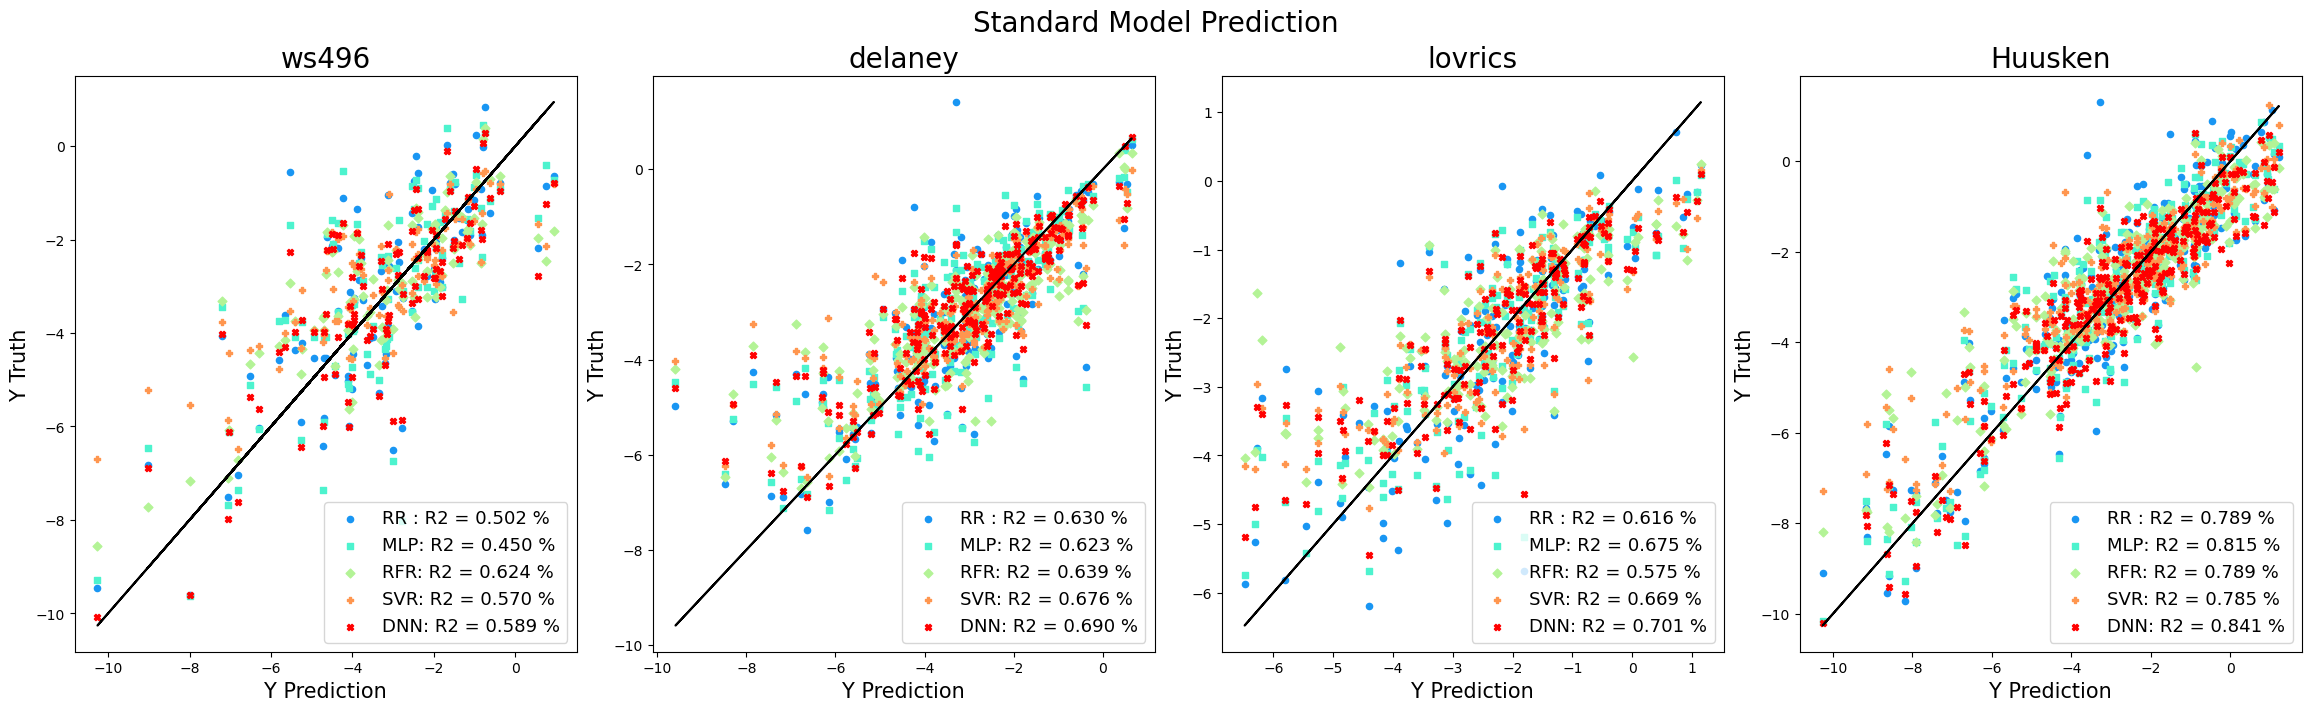

In [80]:
vis_res(res_datasets_ori, 'classic',target_path, b=23)

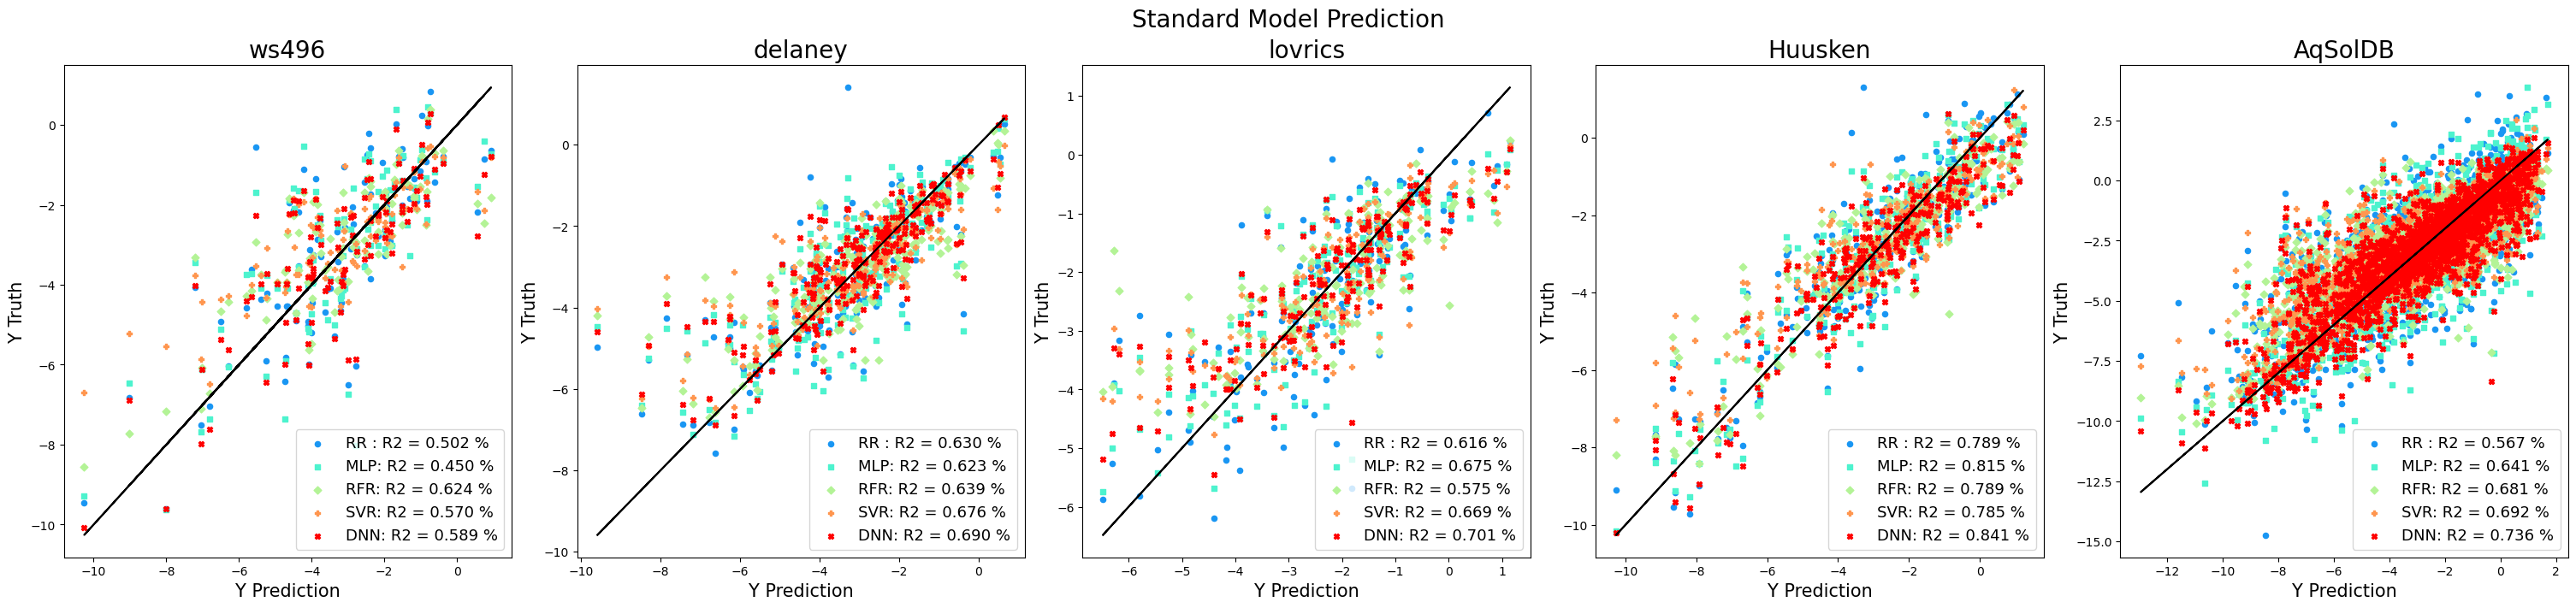

In [81]:
vis_res(res_datasets_aq, 'AqSol',target_path, b=30)

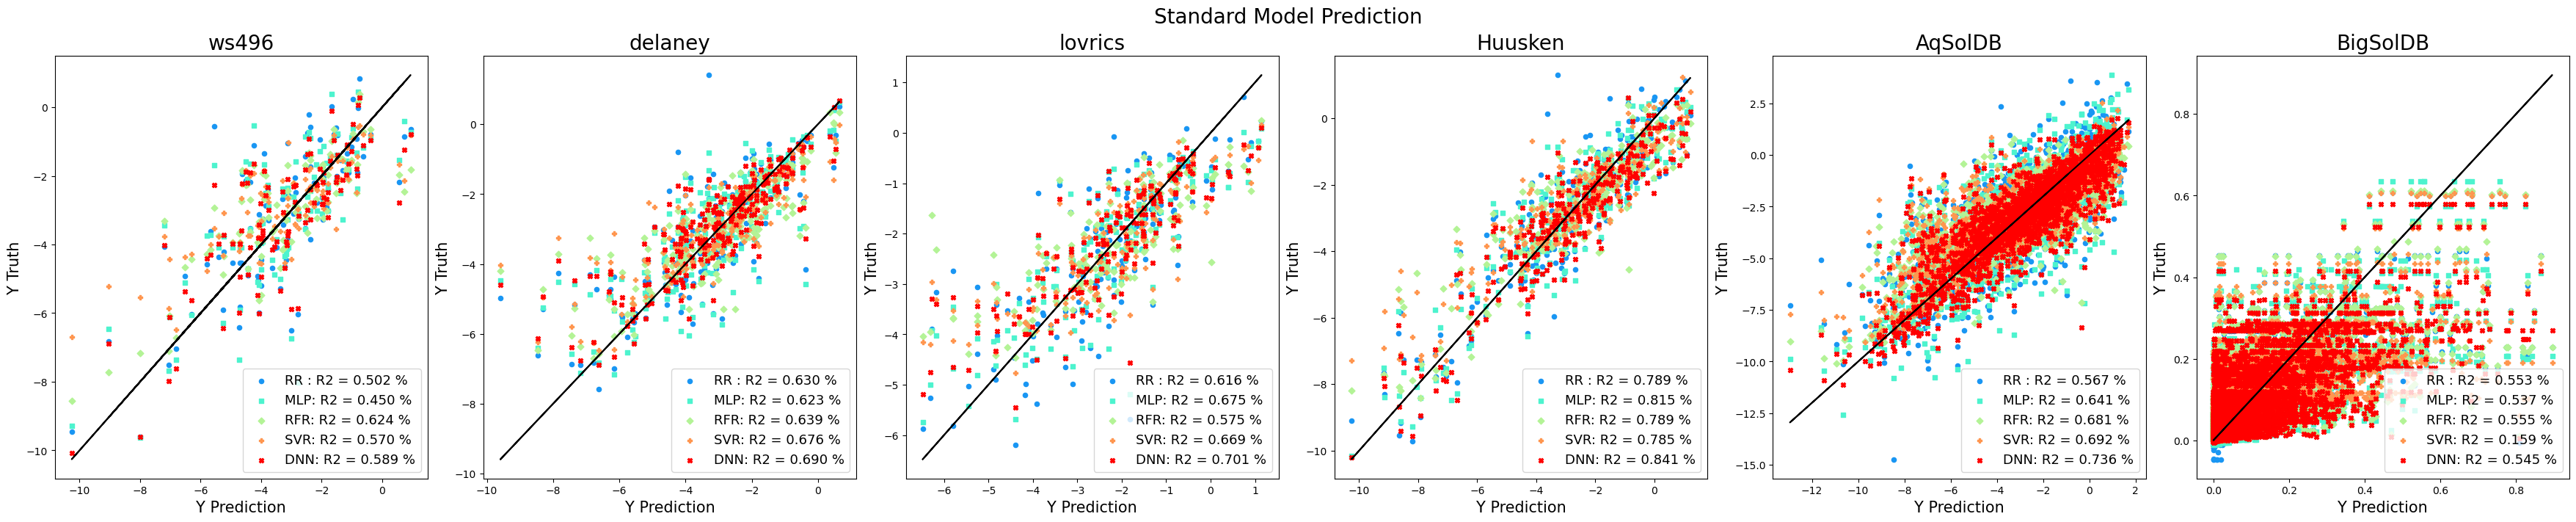

In [82]:
vis_res(res_datasets, 'Bigdata',target_path, b=35)